# 10 Visualization of Results

> *“The presentation of composite indicators and their visualisation affects both relevance and interpretability of the results”*  - OECD and European Commission (2008) Handbook on Constructing Composite Indicators: Methodology and User Guide

In this notebook I will create a suite of charts to communicate both the final CSIAI scores and their underlying drivers.

1. **Bar charts** for ranking and decomposition  
2. **Radar charts** for multidimensional profiles  
3. **Line charts** for time trends  
4. **Heatmaps** for correlation structure 

## 10.1 Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Load processed data
ROOT       = Path("..")
PROC       = ROOT / "data" / "processed"
ART_FIG    = ROOT / "artifacts" / "figures" / "visualization"
ART_FIG.mkdir(parents=True, exist_ok=True)

# Composite index scores and sub-index scores
ci = pd.read_parquet(PROC / "ci_scores.parquet")
if "ticker" in ci.columns:
    ci = ci.set_index("ticker")
sub_scores = pd.read_parquet(PROC / "subindex" / "sub_index_scores.parquet")
if "ticker" in sub_scores.columns:
    sub_scores = sub_scores.set_index("ticker")

## 10.2 Top-10 CSIAI Rankings
Bar chart of the top 10 companies by their PCA weighted linear CSIAI scores.

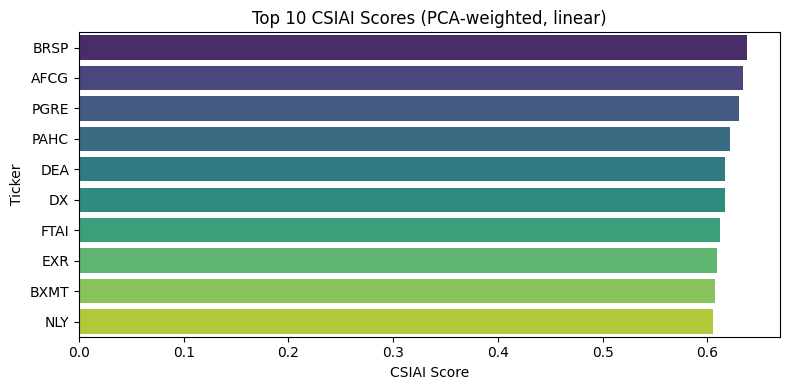

,Rank,ticker,financial_strength_pca,growth_potential_pca,market_performance_pca,risk_volatility_pca,liquidity_trading_pca,CSIAI
36,1,BRSP,0.106,0.079,0.150,0.208,0.094,0.637
1566,2,AFCG,0.092,0.086,0.141,0.219,0.095,0.634
1216,3,PGRE,0.100,0.076,0.151,0.208,0.095,0.630
1037,4,PAHC,0.100,0.072,0.137,0.209,0.103,0.621
421,5,DEA,0.088,0.078,0.152,0.208,0.091,0.617
997,6,DX,0.077,0.086,0.152,0.208,0.093,0.617
1687,7,FTAI,0.133,0.074,0.139,0.166,0.101,0.612
1882,8,EXR,0.096,0.080,0.159,0.188,0.086,0.609
1256,9,BXMT,0.115,0.086,0.160,0.170,0.076,0.608
1601,10,NLY,0.109,0.085,0.160,0.155,0.096,0.605


In [24]:
top10 = ci["CI_pca_lin"].nlargest(10)
plt.figure(figsize=(8,4))
sns.barplot(x=top10.values, y=top10.index, hue=top10.index, palette="viridis", orient="h", dodge=False, legend=False)
plt.title("Top 10 CSIAI Scores (PCA‐weighted, linear)")
plt.xlabel("CSIAI Score")
plt.ylabel("Ticker")
plt.tight_layout()
plt.savefig(ART_FIG / "top10_csiai.png", dpi=300)
plt.show()

# Filter only sub-index columns ending in _pca
pca_cols = [c for c in sub_scores.columns if c.endswith("_pca")]

# Combine sub‐indices (PCA only) + CSIAI
df_rank = sub_scores[pca_cols].join(ci["CI_pca_lin"].rename("CSIAI")).reset_index()

# Compute ranks
df_rank["Rank"] = df_rank["CSIAI"].rank(ascending=False, method="first").astype(int)

# Define final column order
cols = ["Rank", "ticker"] + pca_cols + ["CSIAI"]
df_rank = df_rank[cols].sort_values("Rank")

top20_rank = df_rank.head(20)

display(
    top20_rank.style
         .format({c: "{:.3f}" for c in pca_cols + ["CSIAI"]})
         .set_caption("Top 20 CSIAI Scores (PCA‐weighted, linear)")
         .set_table_attributes('style="border-collapse:collapse"')
)


## 10.3 Sub-Index Decomposition
Bar charts reveal how each sub-index contributes to the final score.  
- X-axis: tickers, stacked bars = sub-indices.  
- Y-axis: composite score.  

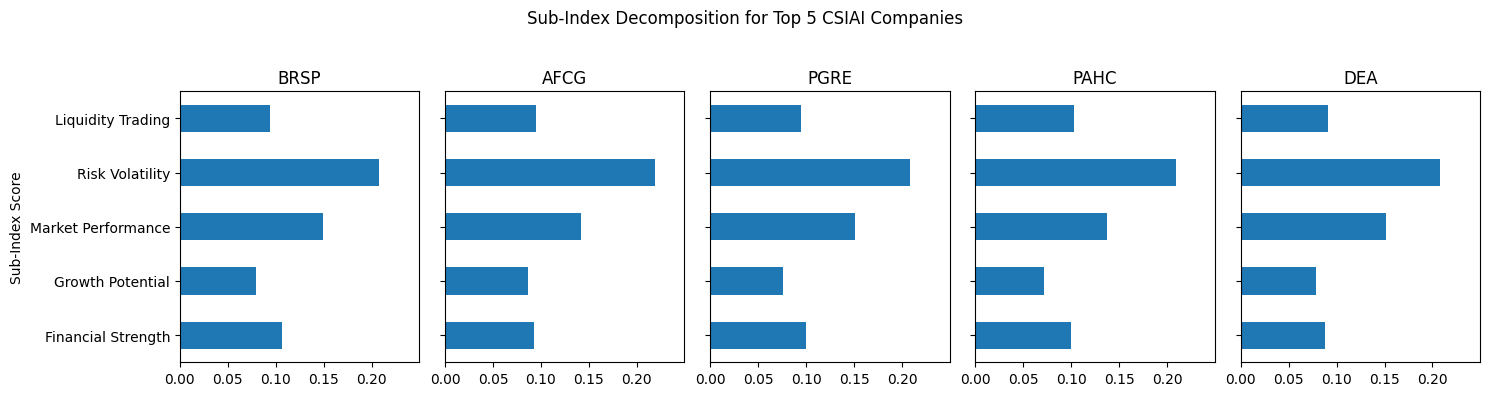

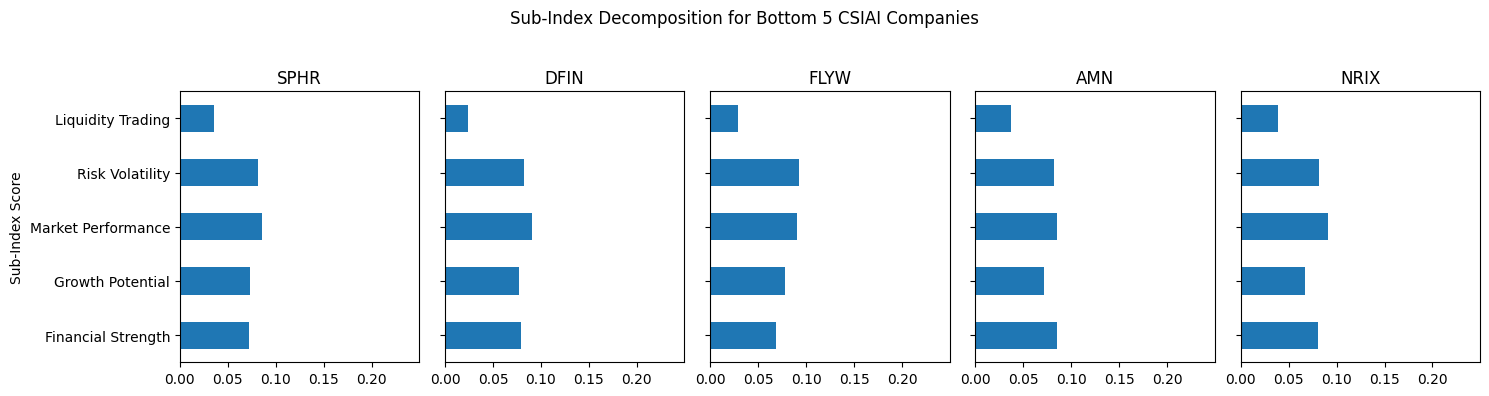

In [10]:
selected = top10.index[:5]
fig, axes = plt.subplots(1, 5, figsize=(15,4), sharey=True)
for ax, tick in zip(axes, selected):
    parts = sub_scores.loc[tick].filter(like="_pca")
    parts.index = [idx.replace("_pca","").replace("_"," ").title() for idx in parts.index]
    parts.plot(kind="barh", ax=ax, legend=False)
    ax.set_title(tick)
    ax.set_xlim(0, sub_scores.filter(like="_pca").values.max()*1.1)
axes[0].set_ylabel("Sub-Index Score")
plt.suptitle("Sub-Index Decomposition for Top 5 CSIAI Companies")
plt.tight_layout(rect=[0,0,1,0.95])
plt.savefig(ART_FIG / "subindex_decomposition.png", dpi=300)
plt.show()

# Plotting the sub index scores for the bottom 5 companies
bottom10 = ci["CI_pca_lin"].nsmallest(10)
selected_bottom = bottom10.index[:5]
fig, axes = plt.subplots(1, 5, figsize=(15,4), sharey=True)
for ax, tick in zip(axes, selected_bottom):
    parts = sub_scores.loc[tick].filter(like="_pca")
    parts.index = [idx.replace("_pca","").replace("_"," ").title() for idx in parts.index]
    parts.plot(kind="barh", ax=ax, legend=False)
    ax.set_title(tick)
    ax.set_xlim(0, sub_scores.filter(like="_pca").values.max()*1.1)
axes[0].set_ylabel("Sub-Index Score")
plt.suptitle("Sub-Index Decomposition for Bottom 5 CSIAI Companies")
plt.tight_layout(rect=[0,0,1,0.95])
plt.savefig(ART_FIG / "subindex_decomposition_bottom.png", dpi=300)
plt.show()


## 10.4 Radar Chart of Profiles
Spider charts show multi-dimensional profiles at a glance.  
- Each axis = one sub-index.  
- Overlay multiple firms for direct comparison.  

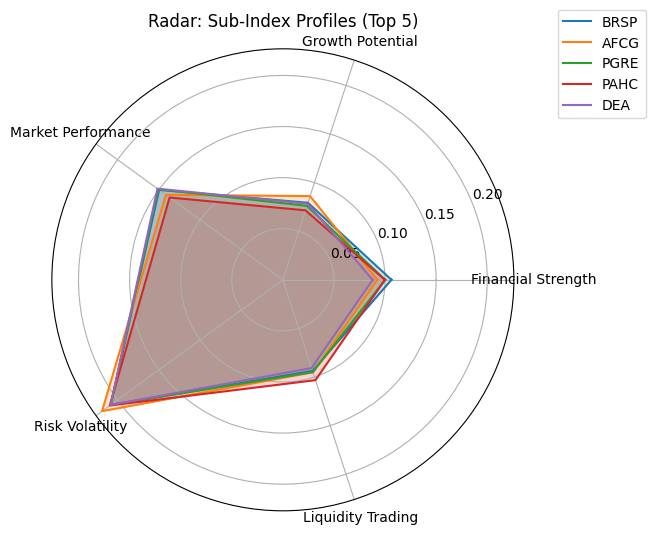

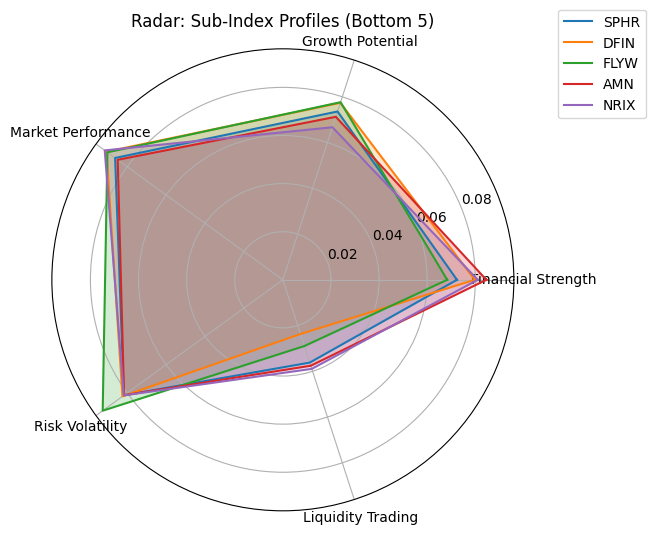

In [12]:
def plot_radar(df, tickers, title, outpath):
    labels = [c.replace("_pca","").replace("_"," ").title() for c in df.columns]
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]
    fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
    for t in tickers:
        values = df.loc[t].tolist()
        values += values[:1]
        ax.plot(angles, values, label=t)
        ax.fill(angles, values, alpha=0.2)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_title(title)
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    plt.savefig(outpath, dpi=300)
    plt.show()

# Radar plot for the top 5 companies
plot_radar(sub_scores.filter(like="_pca"), tickers=selected, title="Radar: Sub-Index Profiles (Top 5)", outpath=ART_FIG / "radar_subindex.png")

# Radar plot for the bottom 5 companies
plot_radar(sub_scores.filter(like="_pca"), tickers=selected_bottom, title="Radar: Sub-Index Profiles (Bottom 5)", outpath=ART_FIG / "radar_subindex_bottom.png")


## 10.5 Time-Series Performance Against SPY, QUAL & MTUM 

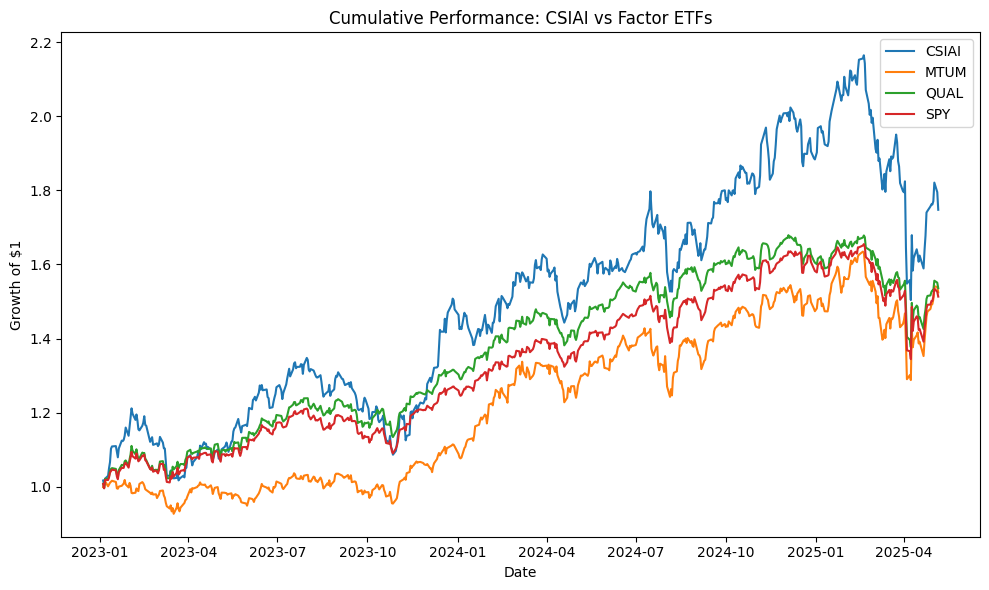

In [ ]:
bench_dir   = ROOT / "artifacts" / "benchmarks"

all_bench = pd.read_csv(bench_dir / "cumulative_comparison.csv", index_col=0, parse_dates=True)
all_bench = all_bench.rename(columns={"CSIAI_Port":"CSIAI"})
all_bench = all_bench.loc[:,["CSIAI","MTUM","QUAL","SPY"]]
all_bench = all_bench.loc[all_bench.index >= "2023-01-04"]
all_bench = all_bench.loc[all_bench.index <= "2025-05-06"]
all_bench = all_bench.dropna()

# Plotting the cumulative performance of CSIAI vs Factor ETFs
plt.figure(figsize=(10,6))
for col in all_bench.columns:
    plt.plot(all_bench.index, all_bench[col], label=col)
plt.title("Cumulative Performance: CSIAI vs Factor ETFs")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.legend()
plt.tight_layout()
plt.savefig(ART_FIG / "cumulative_performance.png", dpi=300)
plt.show()

## 10.6 Correlation Heatmap

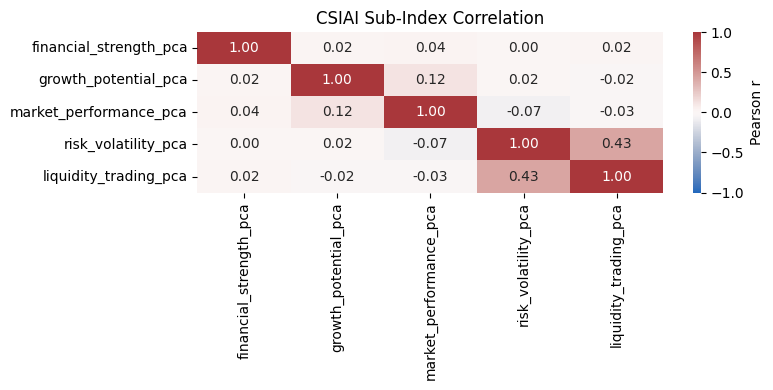

In [18]:
plt.figure(figsize=(8,4))
sns.heatmap(sub_scores.filter(like="_pca").corr(), annot=True, fmt=".2f", cmap="vlag", vmin=-1, vmax=1, cbar_kws=dict(label="Pearson r"))
plt.title("CSIAI Sub-Index Correlation")
plt.tight_layout()
plt.savefig(ART_FIG / "heatmap_subindex_corr.png", dpi=300)
plt.show()